# Evaluating the SQL Agent Benchmarks

The sole purpose of this Evaluation Project, is to test and evaluate the json file from the benchmark. It also contains some graphs to visualize the results.

## Libraries

In [ ]:
!pip install python-Levenshtein
!pip install adjustText

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 161.7/161.7 kB 11.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 70.5 MB/s eta 0:00:00


In [ ]:
import os
from google.colab import drive
import json
import numpy as np
from Levenshtein import distance as levenshtein_distance  # Install with:
import re
import ast
import sqlglot
import math
import sqlglot
from sqlglot.diff import diff
from sqlglot import parse_one
import statistics
from google.cloud import storage
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import plotly.express as px

## Extracting Data

### Google Cloud

In [ ]:
import os
from google.colab import files
import json
# Upload the service account key file
uploaded = files.upload()
key_path = list(uploaded.keys())[0] #gets the uploaded file name.
os.environ["GOOGLE_APPLICATION_CREDENTIALS"] = key_path

Saving dashboard-llm-454014-cf6ca3a07b4e.json to dashboard-llm-454014-cf6ca3a07b4e.json


In [ ]:

def load_json_from_gcs(bucket_name, blob_path):
    """Loads a JSON file from Google Cloud Storage."""
    client = storage.Client()
    bucket = client.bucket(bucket_name)
    blob = bucket.blob(blob_path)

    try:
        json_data = json.loads(blob.download_as_text())
        return json_data
    except Exception as e:
        print(f"Error loading JSON from GCS: {e}")
        return None

In [ ]:
def load_all_json_from_gcs_folder(bucket_name, folder_path):
    """Loads all JSON files from a GCS folder."""
    client = storage.Client()
    bucket = client.bucket(bucket_name)
    blobs = list(client.list_blobs(bucket_name, prefix=folder_path))
    data = []
    json_files = []

    for blob in blobs:
        if blob.name.endswith(".json") and not blob.name.endswith("toxicology_responses.json") :
            json_files.append(blob.name)
            json_data = load_json_from_gcs(bucket_name, blob.name)
            if json_data:
                data.extend(json_data)

    print(f"Loaded {len(data)} entries from {len(json_files)} files.")
    return data

In [ ]:
# Replace with your actual bucket name and folder path
bucket_name = "dashboardllmbucket"
evaluation_folder = "bird-bench/benchmarks" #spider or bird-bench
# evaluation_folder = "spider/benchmarks" #spider or bird-bench

In [ ]:
gemini_folder = os.path.join(evaluation_folder, "refiner_geminiv5/")
# Load all JSON data from the GCS folder
data = load_all_json_from_gcs_folder(bucket_name, gemini_folder)

Loaded 1383 entries from 10 files.


## Evaluating

#### SQL Correctness

##### Levenstein Correctness

In [ ]:
def is_valid_sql(query):
    """Checks if a query resembles a valid SQL statement."""
    if not query or not isinstance(query, str):
        return False
    sql_keywords = ["SELECT", "UPDATE", "DELETE", "INSERT", "FROM", "WHERE", "JOIN", "ORDER BY", "GROUP BY"]
    return any(keyword in query.upper() for keyword in sql_keywords)

In [ ]:
def levenstein_correctness(generated_sqls, correct_sql, threshold=5):
    """
    Evaluates generated SQL queries against a correct SQL, returning 1 if correct,
    0 if incorrect, and None if invalid/empty generated SQLs.
    """
    if not generated_sqls:
        return None

    generated_sqls = [sql.strip().lower() for sql in generated_sqls if is_valid_sql(sql)]
    correct_sql = correct_sql.strip().lower()
    levenshtein_dists = [levenshtein_distance(sql, correct_sql) for sql in generated_sqls]

    if not generated_sqls:
        return None, max(levenshtein_dists)  # All generated SQLs were invalid

    if correct_sql in generated_sqls:
        return 1, max(levenshtein_dists)   # Exact match

    if any(levenshtein_dist < threshold for levenshtein_dist in levenshtein_dists):
        return 0.5, max(levenshtein_dists) #near correct.
    else:
        return 0, max(levenshtein_dists)  # Incorrect

##### Structure correctness

In [ ]:
def extract_structure(sql):
    """Extracts keywords, tables, and columns from a SQL query."""
    keywords = re.findall(r'\b(select|from|where|join|group by|order by)\b', sql)
    tables = re.findall(r'\bfrom\s+([\w_]+)|\bjoin\s+([\w_]+)', sql)
    columns = re.findall(r'([\w_]+)\s*(?:,|\s+from|\s+where|\s+join|\s+group by|\s+order by|$)', sql)

    tables = [item for sublist in tables for item in sublist if item]
    columns = [col for col in columns if col not in ['select','from', 'where', 'join', 'group', 'order', 'by']]
    return keywords, tables, columns

In [ ]:
def structure_correctness(generated_sqls, correct_sql):
    """
    Evaluates generated SQL queries based on structural similarity (keywords, tables, columns).
    Uses a method inspired by SQL similarity metrics in research, specifically considering
    keyword, table, and column set overlap.

    Inspired by:
    - "SQL-specific Text Similarity for Database Schema Matching" by Anastasios Kementsietsidis et al. (SIGMOD 2011)
    - "A Survey on SQL Query Similarity and Clustering" by Zohreh Saadati et al. (Information Systems 2020)

    Returns the highest Jaccard similarity among generated SQLs.
    """
    if not generated_sqls:
        return 0.0

    generated_sqls = [sql.strip().lower() for sql in generated_sqls if sql and isinstance(sql, str)]
    correct_sql = correct_sql.strip().lower()

    if not generated_sqls:
        return 0.0

    def extract_features(sql):
        """Extracts keywords, tables, and columns as sets for Jaccard similarity."""
        keywords = set(re.findall(r'\b(select|from|where|join|group by|order by)\b', sql))
        tables = set(re.findall(r'\bfrom\s+([\w_]+)|\bjoin\s+([\w_]+)', sql))
        tables = {item for sublist in tables for item in sublist if item}
        columns = set(re.findall(r'([\w_]+)\s*(?:,|\s+from|\s+where|\s+join|\s+group by|\s+order by|$)', sql))
        columns = {col for col in columns if col not in ['select','from', 'where', 'join', 'group', 'order', 'by']}
        return keywords, tables, columns

    correct_keywords, correct_tables, correct_columns = extract_features(correct_sql)

    def jaccard_similarity(set1, set2):
        """Calculates Jaccard similarity between two sets."""
        if not set1 and not set2:
            return 1.0
        if not set1 or not set2:
            return 0.0
        intersection = len(set1.intersection(set2))
        union = len(set1.union(set2))
        return intersection / union if union > 0 else 0.0

    max_similarity = 0.0
    for generated_sql in generated_sqls:
        gen_keywords, gen_tables, gen_columns = extract_features(generated_sql)

        keyword_similarity = jaccard_similarity(gen_keywords, correct_keywords)
        table_similarity = jaccard_similarity(gen_tables, correct_tables)
        column_similarity = jaccard_similarity(gen_columns, correct_columns)

        # Average similarity
        similarity = (keyword_similarity + table_similarity + column_similarity) / 3 if correct_keywords or correct_tables or correct_columns else 0
        max_similarity = max(max_similarity, similarity)

    return max_similarity

##### Skeleton Correctness

In [ ]:
def extract_sql_skeleton(sql):
    """
    Extracts the SQL skeleton by replacing table names, column names, and values with placeholders.
    Uses sqlglot for parsing and manipulation. Handles parsing errors.
    """
    try:
        tree = sqlglot.parse_one(sql)
        if tree is None:
            return ""  # Handle parsing failure

        def replace_nodes(node):
            if isinstance(node, sqlglot.expressions.Table):
                node.set("this", "<table>")
            elif isinstance(node, sqlglot.expressions.Column):
                node.set("this", "<column>")
            elif isinstance(node, sqlglot.expressions.Literal):
                node.set("this", "<value>")
            for child in node.args.values():
                if isinstance(child, sqlglot.expressions.Expression):
                    replace_nodes(child)

        replace_nodes(tree)
        return tree.sql()
    except Exception as e:
        #print(f"Error extracting SQL skeleton: {e}\n  {sql}") #Remove print statement to prevent spamming console.
        return ""  # Return empty string on parsing error

In [ ]:
def edit_distance_skeleton_similarity(skeleton1, skeleton2):
    """
    Calculates the edit distance between two SQL skeletons.
    Uses edit distance as a proxy for structural similarity.

    Based on the method described in:
    "SQL Skeleton Similarity-Based" (Section 3.4.2)
    """
    if not skeleton1 or not skeleton2:
        return 0.0

    distance = levenshtein_distance(skeleton1, skeleton2)
    max_length = max(len(skeleton1), len(skeleton2))
    return 1 - (distance / max_length) if max_length > 0 else 1.0

In [ ]:
def structure_correctness_skeleton(generated_sqls, correct_sql):
    """
    Evaluates generated SQL queries based on SQL skeleton similarity.
    Returns the highest skeleton similarity score.
    """
    if not generated_sqls:
        return 0.0

    generated_sqls = [sql.strip().lower() for sql in generated_sqls if sql and isinstance(sql, str)]
    correct_sql = correct_sql.strip().lower()

    if not generated_sqls:
        return 0.0

    correct_skeleton = extract_sql_skeleton(correct_sql)

    max_similarity = 0.0
    for generated_sql in generated_sqls:
        generated_skeleton = extract_sql_skeleton(generated_sql) #    Extracts the SQL skeleton by replacing table names, column names, and values with placeholders. Uses sqlglot for parsing and manipulation. Handles parsing errors.
        similarity = edit_distance_skeleton_similarity(generated_skeleton, correct_skeleton)
        max_similarity = max(max_similarity, similarity)

    return max_similarity

#### Execution Accuracy

##### Functions

In [ ]:
import re
import math
import itertools

def flatten_list(nested_list):
    """ Recursively flatten a nested list structure into a single list """
    if isinstance(nested_list, list):
        return list(itertools.chain.from_iterable(map(flatten_list, nested_list)))
    return [nested_list]

def extract_components(text):
    if isinstance(text, list):
        text = " ".join(map(str, flatten_list(text)))
    text = str(text)

    numbers = [float(num) for num in re.findall(r"-?\d+\.\d+|-?\d+", text)]
    words = re.findall(r"\b[\w]+\b", text.lower())
    symbols = re.findall(r"[+\-*/=]", text)  # add other symbols as needed

    return set(numbers), set(words), set(symbols)

def is_direct_match(correct_answer, generated_output):
    correct_str = str(correct_answer).lower().strip()
    output_str = str(generated_output).lower().strip()

    return correct_str in output_str or output_str in correct_str


def calculate_match_percentage(correct_answer, generated_output):
    correct_numbers, correct_words, correct_symbols = extract_components(correct_answer)
    gen_numbers, gen_words, gen_symbols = extract_components(generated_output)

    # All unique expected components
    total_expected = (
        len(correct_numbers) + len(correct_words) + len(correct_symbols)
    )
    if total_expected == 0:
        return 100.0 if correct_answer == generated_output else 0.0

    # Total matches
    num_matches = sum(1 for num in correct_numbers if any(math.isclose(num, gen, rel_tol=0.01) for gen in gen_numbers))
    word_matches = sum(1 for word in correct_words if word in gen_words)
    symbol_matches = sum(1 for sym in correct_symbols if sym in gen_symbols)

    total_matches = num_matches + word_matches + symbol_matches
    final_match_percentage = (total_matches / total_expected) * 100

    print(f"Numbers: {num_matches}/{len(correct_numbers)}, Words: {word_matches}/{len(correct_words)}, Symbols: {symbol_matches}/{len(correct_symbols)}")
    return final_match_percentage


In [ ]:
def normalize_sql(query):
    """
    Normalize a SQL query by parsing it, removing table aliases, and formatting it into a standard structure.
    """
    try:
        # Parse the query into an abstract syntax tree (AST)
        parsed = sqlglot.parse_one(query, dialect="mysql")  # Change dialect if needed

        # Remove aliases from tables and subqueries
        def remove_aliases(node):
            if "alias" in node.args:
                node.set("alias", None)  # Remove aliasing
            return node

        normalized = parsed.transform(remove_aliases).sql(dialect="mysql")  # Normalize and format
        return normalized.lower().strip()  # Case-insensitive comparison

    except Exception as e:
        print(f"Error parsing query: {query}\n{e}")
        return None  # Return None if the query is invalid

def compare_sql_queries(query1, query2):
    """
    Compare two SQL queries by normalizing their structure and checking if they match.
    """
    norm_query1 = normalize_sql(query1)
    norm_query2 = normalize_sql(query2)

    if norm_query1 is None or norm_query2 is None:
        return False  # Invalid SQL queries

    return norm_query1 == norm_query2

In [ ]:
def round_numbers(text, decimal_places=2):
    """
    Rounds numbers in a text to a specified number of decimal places,
    handling percentages correctly.
    """

    def replace_number(match):
        number_str = match.group(0)
        if number_str.endswith("%"):
            number = float(number_str[:-1]) / 100.0
        else:
            number = float(number_str)
        rounded_number = round(number, decimal_places)
        return str(rounded_number)

    pattern = r"\d+\.?\d*%"  # Matches numbers with %
    text = re.sub(pattern, replace_number, text)

    pattern = r"\d+\.?\d*" #matches normal numbers
    text = re.sub(pattern, replace_number, text)

    return text

##### Calculate

In [ ]:
from more_itertools import collapse
# 1. Round only true numbers in any string, leave alphanumeric alone
def round_all_floats_in_string(text):
    return re.sub(
        r'(?<![A-Za-z0-9])(\d+\.\d+|\d+)(?![A-Za-z0-9])',
        lambda m: f"{float(m.group()):.2f}",
        text
    )

# 2. Smart‐round a single element: int/float → “xx.xx”, numeric string → “xx.xx”, else leave
def smart_round(elem):
    # if already int/float
    if isinstance(elem, (int, float)):
        return f"{float(elem):.2f}"
    # if pure numeric string
    if isinstance(elem, str) and re.fullmatch(r"\d+(\.\d+)?", elem):
        return f"{float(elem):.2f}"
    # else round only standalone numbers inside text
    return round_all_floats_in_string(str(elem))

# 3. Apply smart_round to every element of a parsed list-of-tuples
def round_elements_in_tuple_list(data):
    result = []
    for entry in data:
        rounded_entry = tuple(smart_round(e) for e in entry)
        result.append(rounded_entry)
    return result

# 4. Parse a string like "[('81.00',)]" into a normalized tuple-list
def normalize_tuple_list(data_str):
    try:
        parsed = ast.literal_eval(data_str)
        return round_elements_in_tuple_list(parsed)
    except:
        return []

# 5. Detect common “no-answer” or error messages
def contains_error_message(output):
    error_phrases = [
        "i am sorry", "max iterations", "cannot answer", "is none",
        "no data", "another way", "does not have", "unable to",
        "not in the database", "does not contain any", "operationalerror", "sqlite3.operationalerror"
    ]
    return any(
        any(err in str(item).lower() for err in error_phrases)
        for item in collapse(output)
    )

In [ ]:
# 6. Flatten and parse both your two formats of generated_direct_output:
def flatten_generated_output(output):
    results = []
    for raw_item in output:
        # unify into list
        items = raw_item if isinstance(raw_item, list) else [raw_item]
        for item in items:
            # if it’s a single‐element list, drill in
            if isinstance(item, list) and len(item) == 1:
                item = item[0]

            # Now item is either str/float/int/other
            if isinstance(item, str):
                # strip quotes, try full‐string parse
                s = item.strip('"\'')
                parsed = normalize_tuple_list(s)
                if parsed:
                    results.extend(parsed)
                else:
                    # treat as a 1‐tuple of smart-rounded text
                    results.append((smart_round(s),))
            elif isinstance(item, (int, float)):
                results.append((f"{float(item):.2f}",))
            else:
                results.append((str(item),))
    return results


def round_float_if_possible(val):
    """Try to convert to float and round; otherwise return as is."""
    try:
        return round(float(val), 2)
    except (ValueError, TypeError):
        return val  # Return the value unchanged if it's not a valid float

In [ ]:
import ast
import re

def is_correct_by_containment(correct_answer, generated_output_str):
    """
    General-purpose: returns True if all elements or element pairs from correct_answer
    appear (together or separately) in the generated_output_str.
    Handles 1-element and 2-element tuples of strings or numbers.
    """
    text = smart_round(generated_output_str.lower().replace("–", "-").replace("—", "-"))

    # try:
    # Convert string representation of the correct answer into a list of tuples
    parsed = ast.literal_eval(correct_answer)
    rounded = round_elements_in_tuple_list(parsed)
    for guess in rounded:
        for element in guess:
          if element.lower() not in text:
              # print("element", guess)
              # print("text", text)
              return False
    return True


In [ ]:
import ast
import re


def calculate_execution_accuracy(correct_answer_str, generated_output, generated_direct_output):
    # Process the correct answer by rounding elements and converting to a set of tuples
    processed_answer = round_elements_in_tuple_list(ast.literal_eval(correct_answer_str))

    # Process generated outputs by flattening the generated response
    generated_answers = flatten_generated_output(generated_direct_output)

    processed_set = set(tuple(map(str, item)) for item in processed_answer)
    generated_set = set(tuple(map(str, item)) for item in generated_answers)

    # print("correct_answer_str", str(correct_answer_str))
    # print("generated_output", generated_output)

    # Check if the sets have any common elements
    if processed_set & generated_set:
        return 1, "Correct"
    # Check for containment matches (i.e., correct answer elements are found in the output text)
    elif is_correct_by_containment(str(correct_answer_str), generated_output):
        # print("is_correct_by_containment")
        return 1, "Correct"
    # Handle cases where the generated output has errors or no answers
    elif contains_error_message(generated_direct_output) or not generated_answers:
        return 2, "Invalid"
    else:
        return 0, "Failed"

### Main

In [ ]:
sql_correctness_results = []
structure_correctness_results = []
skeleton_correctness_results = []
complexity_scores = []
database_names = []
questions = []
levenshtein_dists_results = []
answers = []
generated_answers = []
first_valid_sqls = []
correct_sql_results = []

sql_accuracy_results = []
structure_accuracy_results = []

accuracy_scores = []
accuracy_scores_per_db = {}
run_times = []
execution_times = []

accuracy_scores_per_complexity = {}

for item in data:
  database_name = item["database_name"]
  question_number = item["question_number"]
  question = item["question"]
  complexity_scores.append(item['difficulty'])
  correct_sql = item["correct_sql"]
  correct_answer_str = item["correct_answer"]
  generated_output = item["generated_output"]
  generated_direct_output = item["generated_direct_output"]
  run_times.append(item["time_spent"])
  execution_times.append(item["generated_query_runtime"])

  answers.append(correct_answer_str)
  generated_answers.append(generated_direct_output)
  database_names.append(database_name)
  questions.append(question)
  correct_sql_results.append(correct_sql)

  try:
    if item["generated_sqls"] != None:
      generated_sqls = item["generated_sqls"]
    else:
      generated_sqls = []
  except KeyError:
    generated_sqls = []

  generated_sqls = [sql for sql in generated_sqls if is_valid_sql(sql)]  # Filter out invalid SQL
  try:
    first_valid_sqls.append(generated_sqls[0])
  except IndexError:
    first_valid_sqls.append("Invalid")
    generated_sqls = ["SELECT Invalid"]

  # dict_direct_output = [f"{i + 1}: {x}" for i, x in enumerate(generated_direct_output) if "Incorrect Query" not in x]


  # print("generated_sqls: ", generated_sqls)
  # print("correct_sqls: ", correct_sql)
  '''SQL Correctness'''
  sql_correctness_result, levenshtein_dists_result = levenstein_correctness(generated_sqls, correct_sql)
  levenshtein_dists_results.append(levenshtein_dists_result)
  sql_correctness_results.append(sql_correctness_result)
  structure_correctness_results.append(structure_correctness(generated_sqls, correct_sql))
  skeleton_correctness_results.append(structure_correctness_skeleton(generated_sqls, correct_sql)) #https://arxiv.org/pdf/2412.12522

  '''Answer Correctness'''
  if generated_output == "" or generated_output == None or generated_direct_output == [['']] or correct_answer_str == "ANSWER IS INCORRECT: INVALID QUESTION" or correct_answer_str == '' or all(item == '' for item in collapse(generated_direct_output)):
    correct_answer = None
    generated_output = None
    accuracy_scores.append(2) #invalid
    continue
  else:
    score, status = calculate_execution_accuracy(correct_answer_str, generated_output, generated_direct_output)
    accuracy_scores.append(score)
    if database_name not in accuracy_scores_per_db:
      accuracy_scores_per_db[database_name] = []
    accuracy_scores_per_db[database_name].append(score)

    if item['difficulty'] not in accuracy_scores_per_complexity:
      accuracy_scores_per_complexity[item['difficulty']] = []

    accuracy_scores_per_complexity[item['difficulty']].append(score)

  '''Results'''
  if status == "Failed": #Correct, Invalid or Failed
    print(f"{status} Match in database {item['database_name']} for question {item['question_number']}:")
    print(f"  Question: {item['question']}")
    print(f"  Correct answer: {correct_answer_str}")
    print(f"  Direct output: {generated_output}")
    for index, output in enumerate(generated_direct_output):
      print(f"  Generated Output: {output}")

    print("")
    print(f"  Correct Query:     {correct_sql}")
    for index, sql_query in enumerate(generated_sqls):
      print(f"  Generated Query {index+1}: {sql_query}")

    # print(f"  Generated Query: {item['generated_sqls']}")
    # print(f"  Match percentage: {match_percentage}%")
    # print(f"  Direct match percentage: {direct_match_collection}")
    print("-" * 50)
    print("")

# Filter out invalids (2) for normal accuracy
valid_scores = [s for s in accuracy_scores if s in [0, 1]]
correct_scores = [s for s in valid_scores if s == 1]
invalid_scores = accuracy_scores.count(2)

# Normal accuracy (ignores invalids)
if len(valid_scores) > 0:
    accuracy = len(correct_scores) / len(valid_scores) * 100
    sql_correctnesss_accuracy = statistics.mean(sql_correctness_results)
    structure_correctness_accuracy = statistics.mean(structure_correctness_results)
    skeleton_correctness_accuracy = statistics.mean(skeleton_correctness_results)
    levenshtein_dists_accuracy = statistics.mean(levenshtein_dists_results)
    average_run_time = statistics.mean(run_times)
    print(execution_times)
    average_execution_time = statistics.mean([x for x in collapse(execution_times) if x is not None])
else:
    accuracy = 0
    sql_correctnesss_accuracy = 0
    structure_correctness_accuracy = 0
    skeleton_correctness_accuracy = 0
    levenshtein_dists_accuracy = 0
    average_run_time = 0
    average_execution_time = 0

# Total accuracy (counts invalids as incorrect)
total_attempts = len(accuracy_scores)
total_accuracy = len(correct_scores) / total_attempts * 100 if total_attempts > 0 else 0

print(f"Execution Accuracy (without invalid): {accuracy:.2f}%")
print(f"SQL Correctness Accuracy: {sql_correctnesss_accuracy:.2f}%")
print(f"Structure Correctness Accuracy: {structure_correctness_accuracy:.2f}%")
print(f"Skeleton Correctness Accuracy: {skeleton_correctness_accuracy:.2f}%")
print(f"Avg. Levenshtein Distances: {levenshtein_dists_accuracy:.2f}")
print(f"Average Run Time: {average_run_time:.2f} seconds")
print(f"Average Execution Time: {average_execution_time} seconds")
print(f"Total Accuracy (with invalid as incorrect): {total_accuracy:.2f}%")
print(f"Invalid Scores: {invalid_scores}")
print(f"Total Scores: {total_attempts}")

for db, scores in accuracy_scores_per_db.items():
  valid = [s for s in scores if s in [0, 1]]
  correct = [s for s in valid if s == 1]
  if len(valid) > 0:
    accuracy = len(correct) / len(valid) * 100
  else:
    accuracy = 0
  print(f"DB {db}: {accuracy:.2f}%")

print("Execution Accuracy by Query Complexity:")
for complexity, scores in accuracy_scores_per_complexity.items():
    valid = [s for s in scores if s in [0, 1]]
    correct = [s for s in valid if s == 1]
    if len(valid) > 0:
        acc = len(correct) / len(valid) * 100
    else:
        acc = 0
    print(f"  {complexity.capitalize()}: {acc:.2f}% of {len(valid)} queries")

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
# print(sql_correctness_results)
# print(structure_correctness_results)
# print(levenshtein_dists_results)
# print(skeleton_correctness_results)
# print(accuracy_scores)
# print(complexity_scores)
# print(database_names)
# for x in [sql_correctness_results, structure_correctness_results, skeleton_correctness_results, levenshtein_dists_results, accuracy_scores, complexity_scores, database_names, questions, answers,  correct_sql_results, first_valid_sqls, levenshtein_dists_results]:
#   print(len(x))

1384
1384
1384
1384
1384
1384
1384
1384
1384
1384
1384
1384


### New Graphs

In [ ]:
shot_type = 20  # or 3, or 5 depending on the current run
agent_usage =  "Refiner"
# Add the shot type column
df_current = pd.DataFrame({
    'SQL Correctness': sql_correctness_results,
    'Structure Correctness': structure_correctness_results,
    'Skeleton Correctness': skeleton_correctness_results,
    'Complexity Score': complexity_scores,
    'Database': database_names,
    'Accuracy Scores': accuracy_scores,
    'Questions': questions,
    'Answers': answers,
    'Correct SQL': correct_sql_results,
    'First Valid SQL': first_valid_sqls,
    'Levenshtein Distances': levenshtein_dists_results,
    'Shot Type': shot_type,
    'Execution times': execution_times,
    'Run times': run_times,
    'Agent Usage': agent_usage
})

# Append to a global dataframe that you maintain across runs
if 'df_combined' not in globals():
    df_combined = df_current.copy()
elif shot_type not in list(df_combined['Agent Usage']):
    df_combined = pd.concat([df_combined, df_current], ignore_index=True)
else:
  print("nothing happened")

In [ ]:
print(df_combined['Agent Usage'].unique())
print(df_combined['Accuracy Scores'].unique())

['Refiner' 'Senior' 'Single']
[1 0 2]


In [ ]:
# '''top levenstein distances dataframe'''
# pd.set_option('display.max_rows', None)
# pd.set_option('display.max_columns', None)
# pd.set_option('display.width', 2000)
# pd.set_option('display.float_format', '{:20,.2f}'.format)
# pd.set_option('display.max_colwidth', None)
# print(df.columns)
# df.sort_values(by=['Levenshtein Distances'], ascending=False).head(7)

In [ ]:
pd.reset_option('display.max_rows')
pd.reset_option('display.max_columns')
pd.reset_option('display.width')
pd.reset_option('display.float_format')
pd.reset_option('display.max_colwidth')

#### multi over single

/tmp/ipython-input-162-1147727703.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=ablation_data, x="Agent Stage", y="Correctness", palette="viridis")


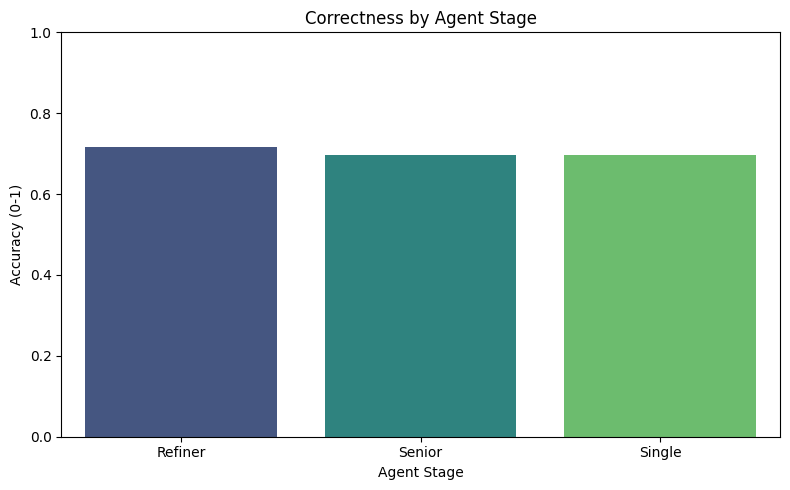

In [ ]:
# Filter out invalid entries (accuracy score == 2)
df_valid = df_combined[df_combined["Accuracy Scores"] != 2]

# 1. Ablation Bar Chart of Correctness by Agent Stage
ablation_data = df_valid.groupby("Agent Usage")["Accuracy Scores"].mean().reset_index()
ablation_data.columns = ["Agent Stage", "Correctness"]

plt.figure(figsize=(8, 5))
sns.barplot(data=ablation_data, x="Agent Stage", y="Correctness", palette="viridis")
plt.title("Correctness by Agent Stage")
plt.ylabel("Accuracy (0-1)")
plt.xlabel("Agent Stage")
plt.ylim(0, 1)
plt.tight_layout()
plt.show()

/tmp/ipython-input-163-3254594666.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=labels, y=cumulative, palette="cubehelix")


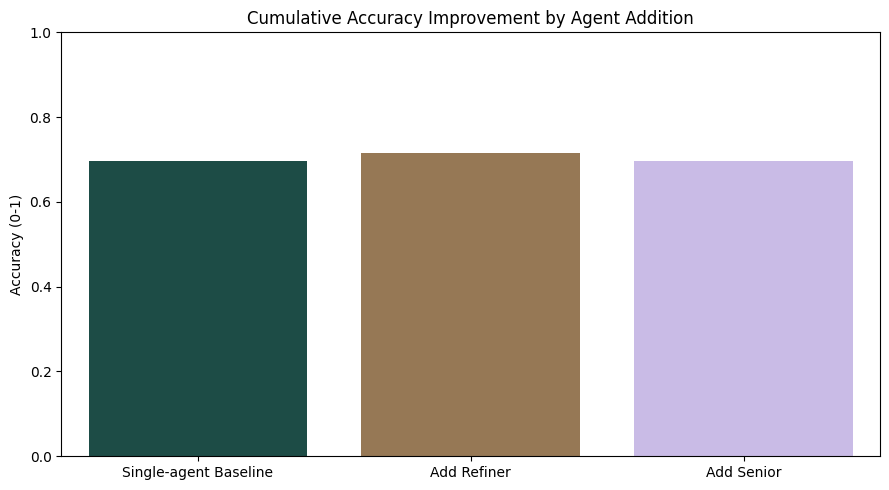

In [ ]:
base = df_valid[df_valid["Agent Usage"] == "Single"]["Accuracy Scores"].mean()
refiner = df_valid[df_valid["Agent Usage"] == "Refiner"]["Accuracy Scores"].mean()
senior = df_valid[df_valid["Agent Usage"] == "Senior"]["Accuracy Scores"].mean()

improvements = [base, refiner - base, senior - refiner]
labels = ["Single-agent Baseline", "Add Refiner", "Add Senior"]

cumulative = [improvements[0], improvements[0] + improvements[1], improvements[0] + improvements[1] + improvements[2]]

plt.figure(figsize=(9, 5))
sns.barplot(x=labels, y=cumulative, palette="cubehelix")
plt.title("Cumulative Accuracy Improvement by Agent Addition")
plt.ylabel("Accuracy (0-1)")
plt.ylim(0, 1)
plt.tight_layout()
plt.show()

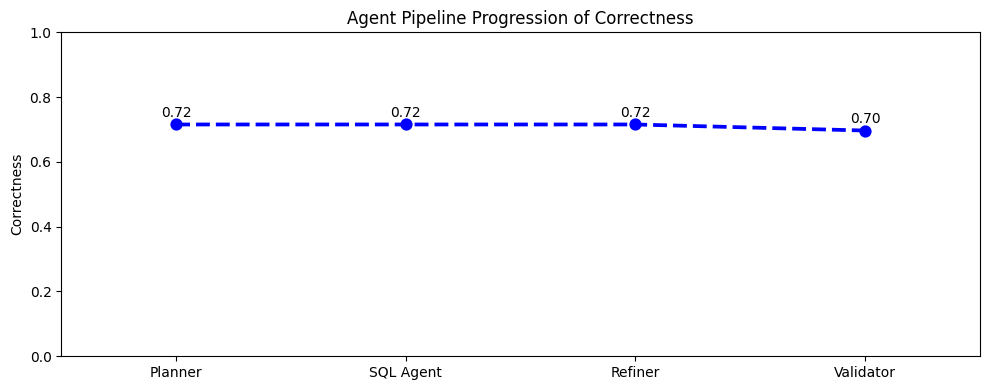

In [ ]:
pipeline_metrics = {
    "Database Only": df_valid[df_valid["Agent Usage"] == "Refiner"]["Accuracy Scores"].mean(),
    "Senior": df_valid[df_valid["Agent Usage"] == "Refiner"]["Accuracy Scores"].mean(),
    "Refiner": df_valid[df_valid["Agent Usage"] == "Refiner"]["Accuracy Scores"].mean(),
    "Validator": df_valid[df_valid["Agent Usage"] == "Senior"]["Accuracy Scores"].mean()
}

stages = list(pipeline_metrics.keys())
values = list(pipeline_metrics.values())

plt.figure(figsize=(10, 4))
sns.pointplot(x=stages, y=values, markers="o", linestyles="--", color="blue")
for i, val in enumerate(values):
    plt.text(i, val + 0.015, f"{val:.2f}", ha='center', va='bottom')
plt.title("Agent Pipeline Progression of Correctness")
plt.ylabel("Correctness")
plt.ylim(0, 1)
plt.tight_layout()
plt.show()

#### Schema complexity

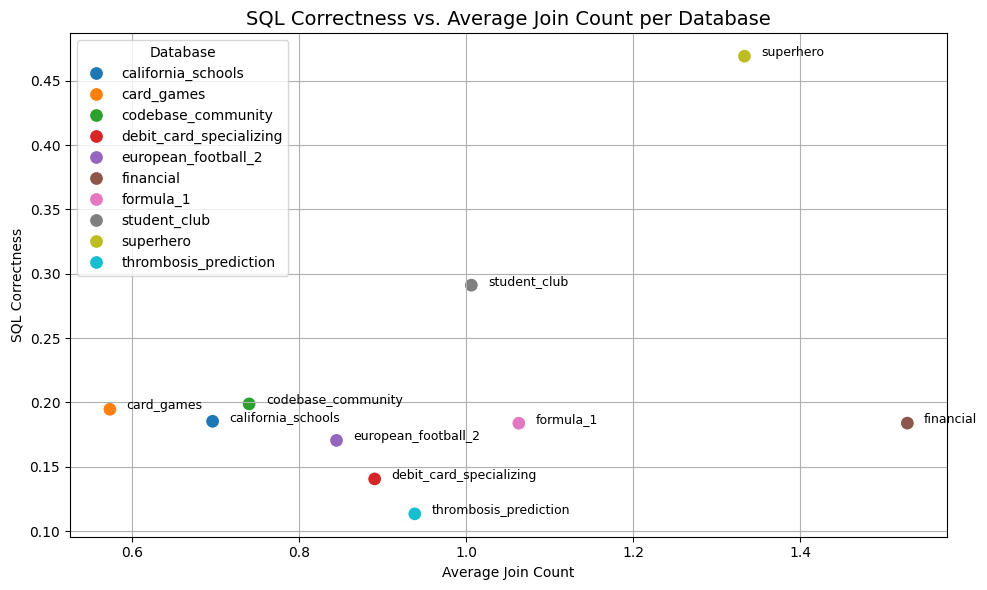

In [ ]:
df = df_current.copy()
df["Join Count"] = df["Correct SQL"].str.lower().str.count(" join ")

# Aggregate: Average join count and SQL correctness per database
df_join_summary = df.groupby("Database").agg({
    "Join Count": "mean",
    "SQL Correctness": "mean"
}).reset_index()

# Plot
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df_join_summary, x="Join Count", y="SQL Correctness", hue="Database", s=100, palette="tab10")

for i in range(df_join_summary.shape[0]):
    plt.text(
        df_join_summary["Join Count"][i] + 0.02,
        df_join_summary["SQL Correctness"][i],
        df_join_summary["Database"][i],
        fontsize=9
    )

plt.title("SQL Correctness vs. Average Join Count per Database", fontsize=14)
plt.xlabel("Average Join Count")
plt.ylabel("SQL Correctness")
plt.grid(True)
plt.tight_layout()
plt.show()

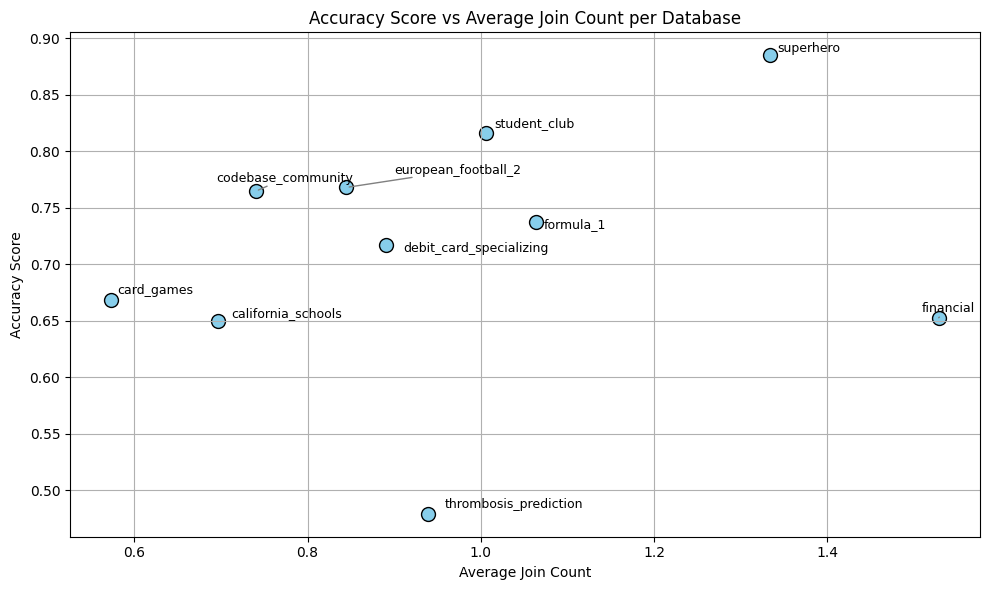

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from adjustText import adjust_text

# Count JOIN occurrences in each correct SQL (case-insensitive)
df_current['Join Count'] = df_current['Correct SQL'].str.upper().str.count(r'\bJOIN\b')

# Group by database
def accuracy_score(x):
    x = x[x != 2]  # exclude invalids
    return (x == 1).sum() / len(x) if len(x) > 0 else 0

grouped = df_current.groupby('Database').agg({
    'Join Count': 'mean',
    'Accuracy Scores': accuracy_score
}).reset_index()

# Plotting
plt.figure(figsize=(10, 6))
plt.scatter(grouped['Join Count'], grouped['Accuracy Scores'], s=100, c='skyblue', edgecolors='black')

# Prepare labels for adjustment
texts = []
for _, row in grouped.iterrows():
    texts.append(plt.text(row['Join Count'], row['Accuracy Scores'], row['Database'], fontsize=9))

# Adjust labels to prevent overlap
adjust_text(texts, arrowprops=dict(arrowstyle='-', color='gray'))

plt.xlabel('Average Join Count')
plt.ylabel('Accuracy Score')
plt.title('Accuracy Score vs Average Join Count per Database')
plt.grid(True)
plt.tight_layout()
plt.show()


/tmp/ipython-input-39-3294337539.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x="Complexity Score", y="SQL Correctness", palette="viridis")


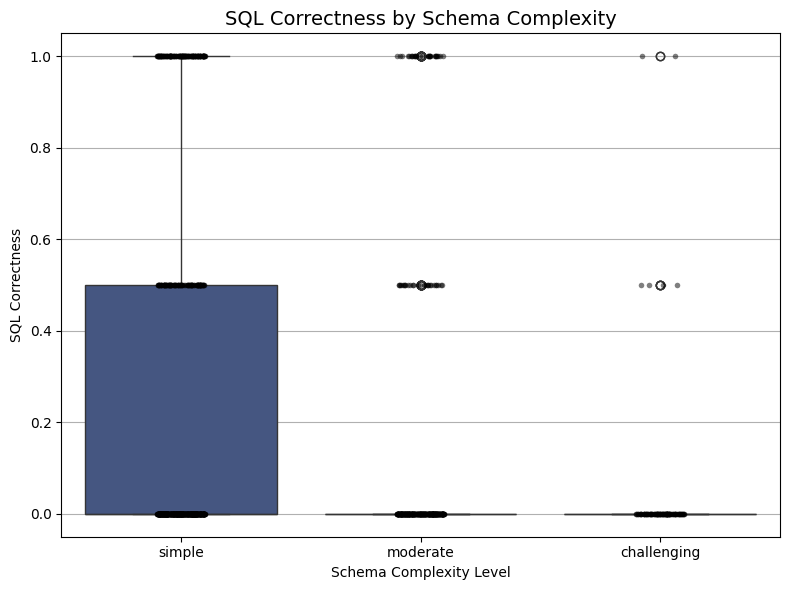

In [ ]:
plt.figure(figsize=(8, 6))
sns.boxplot(data=df, x="Complexity Score", y="SQL Correctness", palette="viridis")
sns.stripplot(data=df, x="Complexity Score", y="SQL Correctness", color="black", size=4, alpha=0.5)

plt.title("SQL Correctness by Schema Complexity", fontsize=14)
plt.ylabel("SQL Correctness")
plt.xlabel("Schema Complexity Level")
plt.grid(True, axis="y")
plt.tight_layout()
plt.show()

In [ ]:
# Function to count joins and subqueries in SQL
def estimate_sql_complexity(sql):
    sql = sql.lower()
    join_count = len(re.findall(r'\bjoin\b', sql))
    subquery_count = len(re.findall(r'\bselect\b.*?\(', sql))  # crude subquery approx
    return join_count, subquery_count

# Create a working copy
df = df_current.copy()

# Apply complexity estimation to SQLs
df[['Join Count', 'Subquery Count']] = df['Correct SQL'].apply(
    lambda sql: pd.Series(estimate_sql_complexity(sql))
)

# Group by database to aggregate schema-level info
schema_complexity_df = df.groupby('Database').agg({
    'Join Count': ['mean', 'max'],
    'Subquery Count': ['mean', 'max'],
    'Correct SQL': 'count'  # proxy for number of queries
})

# Rename columns
schema_complexity_df.columns = [
    'Avg Join Count', 'Max Join Count',
    'Avg Subquery Count', 'Max Subquery Count',
    'Num Queries'
]

# Round averages
schema_complexity_df['Avg Join Count'] = schema_complexity_df['Avg Join Count'].round(2)
schema_complexity_df['Avg Subquery Count'] = schema_complexity_df['Avg Subquery Count'].round(2)

# --- Compute accuracy scores ---
# Only keep valid rows with proper accuracy scores (0, 1, 2)
df_valid = df[df['Accuracy Scores'].isin([0, 1])]

# Compute per-database accuracy: # correct / # (correct + incorrect)
accuracy_df = df_valid.groupby('Database')['Accuracy Scores'].mean().rename('Accuracy Score')

# Merge into complexity table
schema_complexity_df = schema_complexity_df.merge(accuracy_df, left_index=True, right_index=True)

# Desired custom order
desired_order = [
    'financial',
    'superhero',
    'formula_1',
    'student_club',
    'thrombosis_prediction',
    'debit_card_specializing',
    'european_football_2',
    'codebase_community',
    'california_schools',
    'card_games'
]

# Reorder and reset index
schema_complexity_df = schema_complexity_df.loc[desired_order].reset_index()

# Display final result
schema_complexity_df


,Database,Avg Join Count,Max Join Count,Avg Subquery Count,Max Subquery Count,Num Queries,Accuracy Score
0,financial,1.53,4,0.66,2,106,0.652632
1,superhero,1.33,3,0.50,2,129,0.884956
2,formula_1,1.06,6,0.55,7,174,0.737500
3,student_club,1.01,4,0.46,2,158,0.816327
4,thrombosis_prediction,0.94,2,0.71,2,163,0.479167
5,debit_card_specializing,0.89,2,0.75,2,64,0.716667
6,european_football_2,0.84,3,0.71,5,129,0.768000
7,codebase_community,0.74,3,0.67,3,181,0.764706
8,california_schools,0.70,2,0.74,2,89,0.649351
9,card_games,0.57,2,0.45,4,190,0.668790


In [ ]:
# Step 1: Create the structural info DataFrame manually
structure_data = pd.DataFrame({
    'Database': [
        'financial', 'superhero', 'formula_1', 'student_club', 'thrombosis_prediction',
        'debit_card_specializing', 'european_football_2', 'codebase_community',
        'california_schools', 'card_games'
    ],
    'Num Tables': [8, 10, 13, 8, 3, 5, 7, 8, 3, 6],
    'Total Columns': [55, 31, 94, 48, 64, 21, 199, 71, 89, 115],
    'Avg Columns per Table': [6.88, 3.10, 7.23, 6.00, 21.33, 4.20, 28.43, 8.88, 29.67, 19.17],
    'Foreign Key Count': [8, 11, 19, 8, 2, 1, 31, 13, 2, 4],
    'Ambiguous Column Names': [8, 2, 18, 5, 2, 5, 8, 7, 1, 10]
})

# Step 2: Merge with your schema_complexity_df (from earlier)
# Assuming schema_complexity_df already exists and is ordered

# Merge on 'Database'
final_df = pd.merge(schema_complexity_df, structure_data, on='Database', how='left')

# Step 3: Optional — Reorder columns for presentation
final_df = final_df[[
    'Database',
    'Avg Join Count', 'Max Join Count',
    'Avg Subquery Count', 'Max Subquery Count',
    'Accuracy Score',
    'Num Queries',
    'Num Tables', 'Total Columns', 'Avg Columns per Table',
    'Foreign Key Count', 'Ambiguous Column Names'
]]

# Display final table
final_df

,Database,Avg Join Count,Max Join Count,Avg Subquery Count,Max Subquery Count,Accuracy Score,Num Queries,Num Tables,Total Columns,Avg Columns per Table,Foreign Key Count,Ambiguous Column Names
0,financial,1.53,4,0.66,2,0.652632,106,8,55,6.88,8,8
1,superhero,1.33,3,0.50,2,0.884956,129,10,31,3.10,11,2
2,formula_1,1.06,6,0.55,7,0.737500,174,13,94,7.23,19,18
3,student_club,1.01,4,0.46,2,0.816327,158,8,48,6.00,8,5
4,thrombosis_prediction,0.94,2,0.71,2,0.479167,163,3,64,21.33,2,2
5,debit_card_specializing,0.89,2,0.75,2,0.716667,64,5,21,4.20,1,5
6,european_football_2,0.84,3,0.71,5,0.768000,129,7,199,28.43,31,8
7,codebase_community,0.74,3,0.67,3,0.764706,181,8,71,8.88,13,7
8,california_schools,0.70,2,0.74,2,0.649351,89,3,89,29.67,2,1
9,card_games,0.57,2,0.45,4,0.668790,190,6,115,19.17,4,10


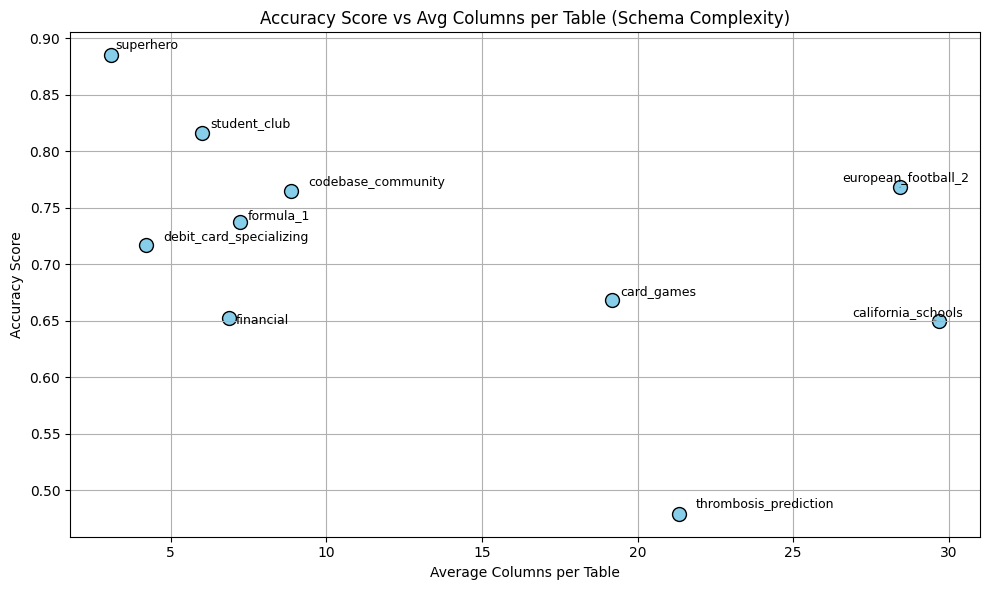

In [ ]:
from adjustText import adjust_text
# Plotting
plt.figure(figsize=(10, 6))
plt.scatter(final_df['Avg Columns per Table'], final_df['Accuracy Score'], s=100, c='skyblue', edgecolors='black')

# Prepare labels for adjustment
texts = []
for _, row in final_df.iterrows():
    texts.append(plt.text(row['Avg Columns per Table'], row['Accuracy Score'], row['Database'], fontsize=9))

# Adjust labels to prevent overlap
adjust_text(texts, arrowprops=dict(arrowstyle='-', color='gray'))

plt.xlabel('Average Columns per Table')
plt.ylabel('Accuracy Score')
plt.title('Accuracy Score vs Avg Columns per Table (Schema Complexity)')
plt.grid(True)
plt.tight_layout()
plt.show()

/tmp/ipython-input-44-2918720200.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=correlations.values, y=correlations.index, palette='coolwarm')


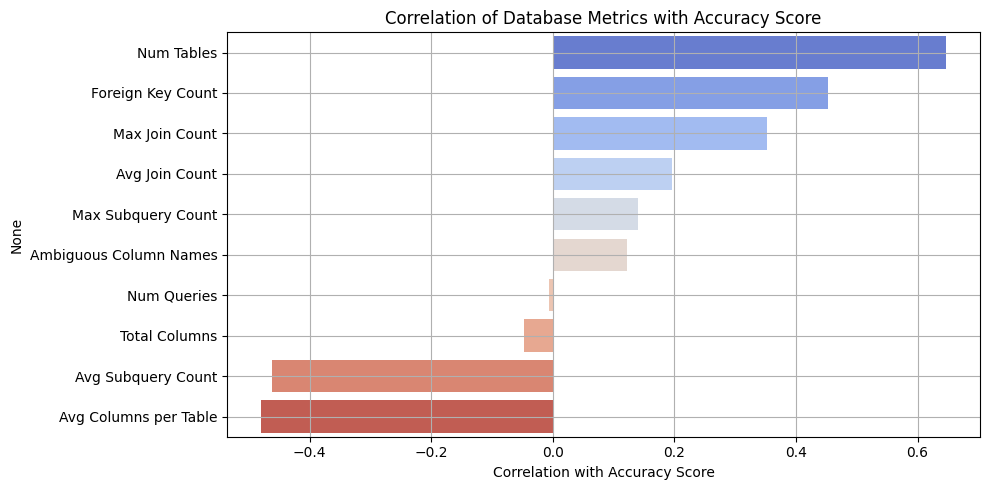

In [ ]:
import seaborn as sns

# Calculate correlation between Accuracy Score and other database metrics
correlations = final_df.corr(numeric_only=True)['Accuracy Score'].drop('Accuracy Score').sort_values(ascending=False)

# Plot correlation heatmap or barplot to visualize strongest correlations
plt.figure(figsize=(10, 5))
sns.barplot(x=correlations.values, y=correlations.index, palette='coolwarm')
plt.xlabel('Correlation with Accuracy Score')
plt.title('Correlation of Database Metrics with Accuracy Score')
plt.grid(True)
plt.tight_layout()
plt.show()

Database charts

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Group and count questions by database and complexity
grouped = df_current.groupby(['Database', 'Complexity Score']).size().unstack(fill_value=0)


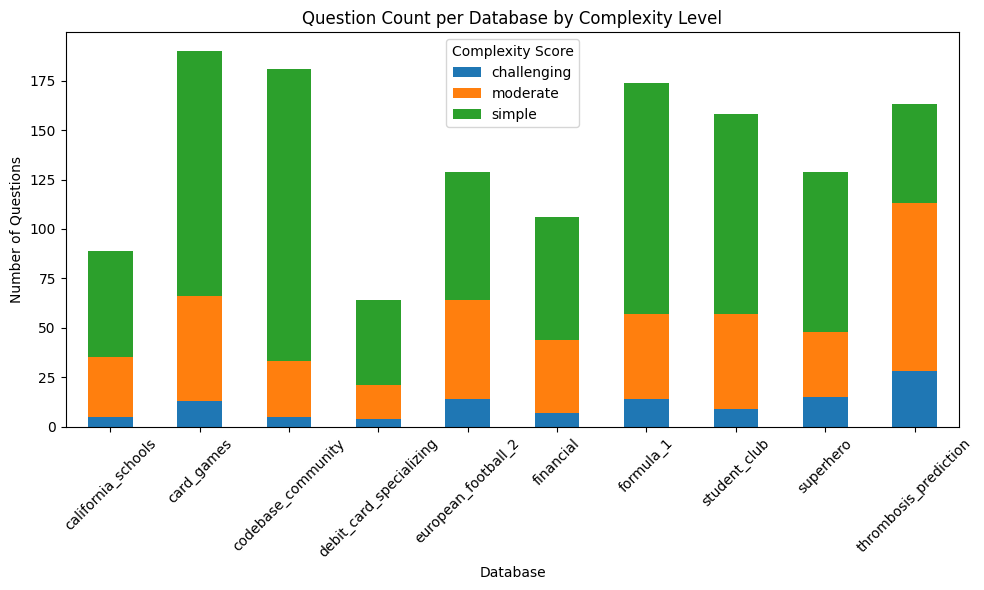

In [ ]:
# Plot as stacked bar chart
grouped.plot(kind='bar', stacked=True, figsize=(10, 6))

plt.title('Question Count per Database by Complexity Level')
plt.xlabel('Database')
plt.ylabel('Number of Questions')
plt.legend(title='Complexity Score')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

#### Few-shot variants

<ipython-input-62-142def61522f>:11: UserWarning: The palette list has more values (3) than needed (2), which may not be intended.
  bar = sns.barplot(


IndexError: list index out of range

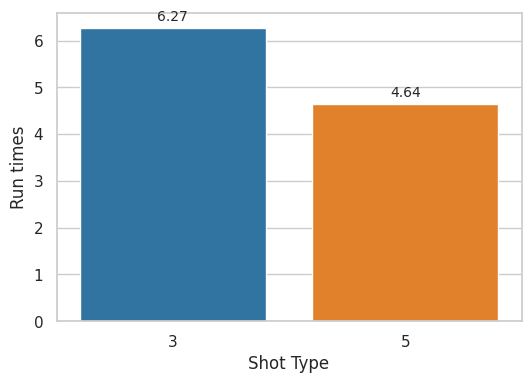

In [ ]:
# Set style and define consistent blue-orange-green color palette
sns.set(style="whitegrid")
colors = ['#1f77b4', '#ff7f0e', '#2ca02c']  # 1-shot, 3-shot, 5-shot

# Group by shot type and calculate average runtime
avg_runtime_per_shot = df_combined.groupby('Shot Type')['Run times'].mean().reset_index()
avg_runtime_per_shot['Shot Type'] = avg_runtime_per_shot['Shot Type'].astype(str)

# Plot
plt.figure(figsize=(6, 4))
bar = sns.barplot(
    data=avg_runtime_per_shot,
    x='Shot Type',
    y='Run times',
    hue='Shot Type',
    palette=colors,
    legend=False
)

# Add bar labels slightly above each bar
bar.bar_label(bar.containers[0], fmt="%.2f", label_type='edge', fontsize=10, padding=3)
bar.bar_label(bar.containers[1], fmt="%.2f", label_type='edge', fontsize=10, padding=3)
bar.bar_label(bar.containers[2], fmt="%.2f", label_type='edge', fontsize=10, padding=3)

# Add vertical buffer to the top of the y-axis
max_val = avg_runtime_per_shot['Run times'].max()
plt.ylim(0, max_val * 1.15)

# Labels and title
bar.set_title("Average Query Runtime by Few-Shot Prompt Size", fontsize=13)
bar.set_xlabel("Few-Shot Prompt Size", fontsize=11)
bar.set_ylabel("Average Runtime (s)", fontsize=11)

plt.tight_layout()
plt.show()

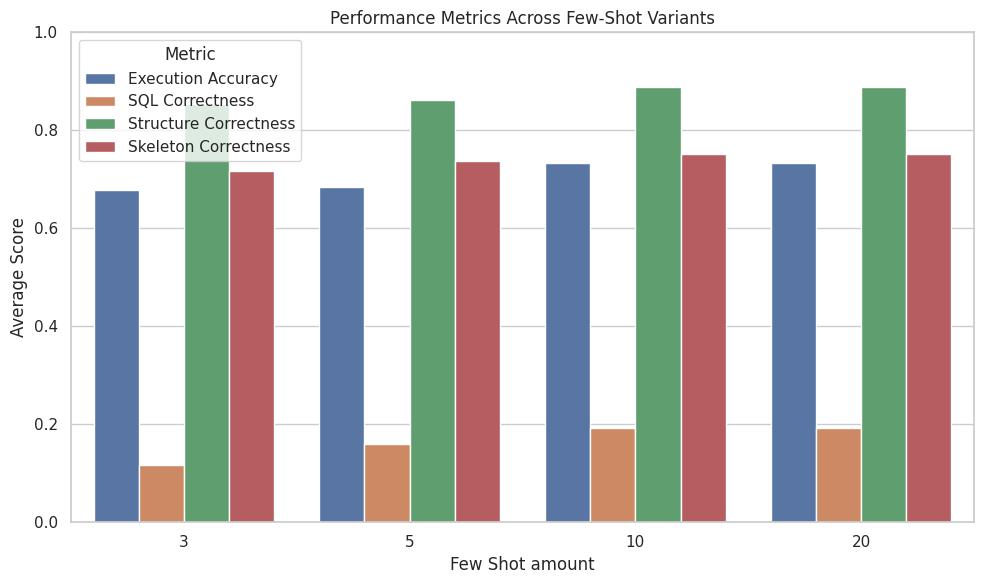

In [ ]:
# Group by shot type and calculate averages
grouped = df_combined[df_combined['Accuracy Scores'] != 2].groupby('Shot Type')[[
    'Accuracy Scores', 'SQL Correctness', 'Structure Correctness', 'Skeleton Correctness'
]].mean().reset_index()

# Rename for clarity
grouped.columns = ['Shot Type', 'Execution Accuracy', 'SQL Correctness', 'Structure Correctness', 'Skeleton Correctness']

# Melt for plotting
melted = pd.melt(grouped, id_vars='Shot Type', var_name='Metric', value_name='Score')

# Plot
plt.figure(figsize=(10, 6))
sns.barplot(data=melted, x='Shot Type', y='Score', hue='Metric')
plt.title('Performance Metrics Across Few-Shot Variants')
plt.ylabel('Average Score')
plt.xlabel('Few Shot amount')
plt.ylim(0, 1)
plt.legend(title='Metric')
plt.tight_layout()
plt.show()


<ipython-input-141-31ff85296e11>:1: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(


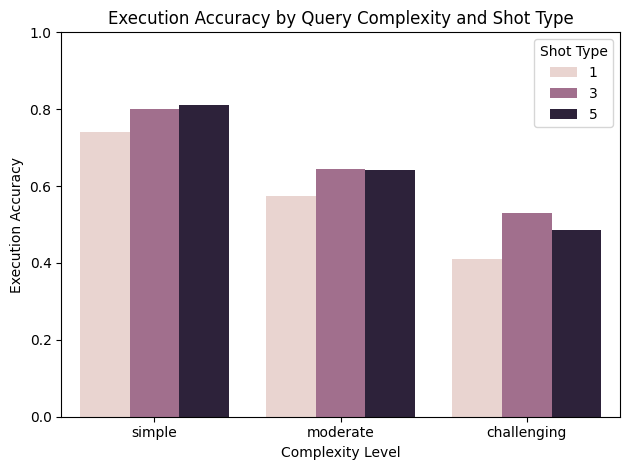

In [ ]:
sns.barplot(
    data=df_combined[df_combined['Accuracy Scores'] != 2],  # exclude invalids
    x='Complexity Score',
    y='Accuracy Scores',
    hue='Shot Type',
    estimator=lambda x: sum(x)/len(x),
    ci=None
)
plt.title('Execution Accuracy by Query Complexity and Shot Type')
plt.ylabel('Execution Accuracy')
plt.xlabel('Complexity Level')
plt.ylim(0, 1)
plt.tight_layout()
plt.show()

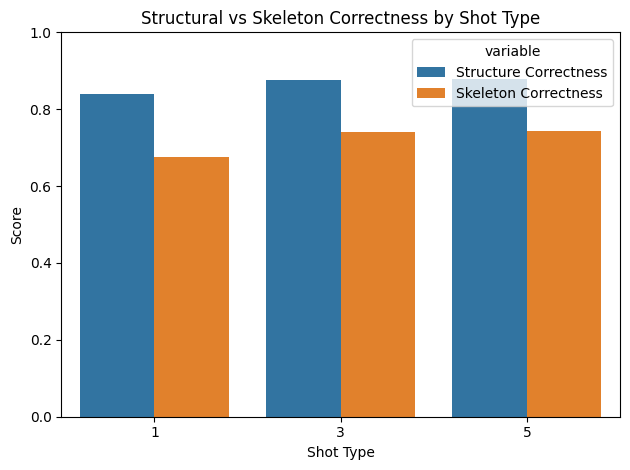

In [ ]:
melted_structure = df_combined.groupby('Shot Type')[['Structure Correctness', 'Skeleton Correctness']].mean().reset_index().melt(id_vars='Shot Type')

sns.barplot(
    data=melted_structure,
    x='Shot Type',
    y='value',
    hue='variable'
)
plt.title('Structural vs Skeleton Correctness by Shot Type')
plt.ylabel('Score')
plt.xlabel('Shot Type')
plt.ylim(0, 1)
plt.tight_layout()
plt.show()


#### Different variants

In [ ]:
print(generated_answers[0])

[['[(1.0,)]', '[(1.0,)]', '[(1.0,)]']]


## OLD GRAPH Maker

In [ ]:
# Create a DataFrame
df = pd.DataFrame({
    'SQL Correctness': sql_correctness_results,
    'Structure Correctness': structure_correctness_results,
    'Skeleton Correctness': skeleton_correctness_results,
    'Complexity Score': complexity_scores,
    'Database': database_names,
    'Accuracy Scores': accuracy_scores,
    'Questions': questions,
    'Answers': answers,
    'Generated Answers': generated_answers,
    'Correct SQL': correct_sql_results,
    'First Valid SQL': first_valid_sqls,
    'Levenshtein Distances': levenshtein_dists_results,
})


df['Correct'] = df['SQL Correctness'].apply(lambda x: 'Correct' if x == 1.0 else 'Incorrect')

# Filter only incorrect for showing question hover
df['Show Question'] = df.apply(lambda row: row['Questions'] if row['Correct'] == 'Incorrect' else '', axis=1)

pd.set_option('display.max_colwidth', None)
df['Complexity Score'].head()

# Function to count JOINs in a SQL query
def count_joins(sql):
    if not isinstance(sql, str):
        return 0
    return len(re.findall(r'\bJOIN\b', sql, flags=re.IGNORECASE))

# Apply the function to your correct SQL queries
df['Join Count'] = df['Correct SQL'].apply(count_joins)

df['Complexity + Joins'] = df.apply(
    lambda row: f"{row['Complexity Score'].capitalize()} ({row['Join Count']} joins)", axis=1
)


In [ ]:
# Define desired complexity order
complexity_order = ['Simple', 'Moderate', 'Challenging']

# Sort all unique combinations of complexity + join count
join_combinations = sorted(
    df[['Complexity Score', 'Join Count']].drop_duplicates().values.tolist(),
    key=lambda x: (complexity_order.index(x[0].capitalize()), x[1])
)

# Create sorted label list
ordered_labels = [f"{comp.capitalize()} ({joins} joins)" for comp, joins in join_combinations]

# Apply this order to the column
df['Complexity + Joins'] = pd.Categorical(df['Complexity + Joins'], categories=ordered_labels, ordered=True)



In [ ]:
import textwrap

# Map accuracy scores
accuracy_map = {1: 'Correct', 0: 'Incorrect', 2: 'Invalid'}
df['Correct Category'] = df['Accuracy Scores'].map(accuracy_map)

# Wrap long text fields for hover display
def wrap_text(text, width=160):
    if not isinstance(text, str):
        return ''
    return '<br>'.join(textwrap.wrap(text, width=width))

df['Wrapped Hover Info'] = (
    'Question:<br>' + df['Show Question'].apply(wrap_text) + '<br><br>' +
    'Answer:<br>' + df['Answers'].apply(wrap_text) + '<br><br>' +
    'Generated Answer:<br>' + df['Generated Answers'].apply(wrap_text) + '<br><br>' +
    'Correct SQL:<br>' + df['Correct SQL'].apply(wrap_text) + '<br><br>' +
    'First Valid SQL:<br>' + df['First Valid SQL'].apply(wrap_text) + '<br><br>' +
    'Levenshtein: ' + df['Levenshtein Distances'].astype(str) + '<br>' +
    'Database: ' + df['Database'].astype(str) + '<br>' +
    'SQL Correctness: ' + df['SQL Correctness'].astype(str)
)


In [ ]:
# Scatter plot
fig = px.scatter(
    df,
    x='Join Count',
    y='Levenshtein Distances',
    color='Correct Category',
    hover_name='Database',
    hover_data={'Wrapped Hover Info': True},
    facet_col='Complexity Score',
    category_orders={'Complexity Score': ['simple', 'moderate', 'challenging']},
    title='SQL Correctness by Complexity and Join Count',
    labels={
        'Join Count': 'Number of JOINs',
        'Levenshtein Distances': 'Levenshtein Distance',
        'Correct Category': 'Result'
    }
)


fig.update_traces(
    marker=dict(size=10, opacity=0.7, line=dict(width=1, color='DarkSlateGrey')),
    hovertemplate='%{customdata[0]}<extra></extra>'
)

# Create count labels per complexity level
counts = df.groupby(['Complexity Score', 'Correct Category']).size().unstack(fill_value=0)

# Adjust x positions for annotation (you can tune these per dataset)
x_positions = {'simple': 0, 'moderate': 1, 'challenging': 2}
for level in ['simple', 'moderate', 'challenging']:
    if level in counts.index:
        row = counts.loc[level]
        text = (
            f"<b>{level.capitalize()}</b><br>"
            f"Correct: {row.get('Correct', 0)}<br>"
            f"Incorrect: {row.get('Incorrect', 0)}<br>"
            f"Invalid: {row.get('Invalid', 0)}"
        )
        fig.add_annotation(
            x=x_positions[level],
            y=df['Levenshtein Distances'].max() + 200,  # Place above highest point
            text=text,
            showarrow=False,
            font=dict(size=12, color="black"),
            align="left",
            bgcolor="lightgray",
            bordercolor="black",
            borderwidth=1,
            borderpad=4
        )

fig.update_layout(
    hovermode='closest',
    height=1000,
    yaxis_range=[0, df['Levenshtein Distances'].max() + 20]
)
fig.show()

Output hidden; open in https://colab.research.google.com to view.

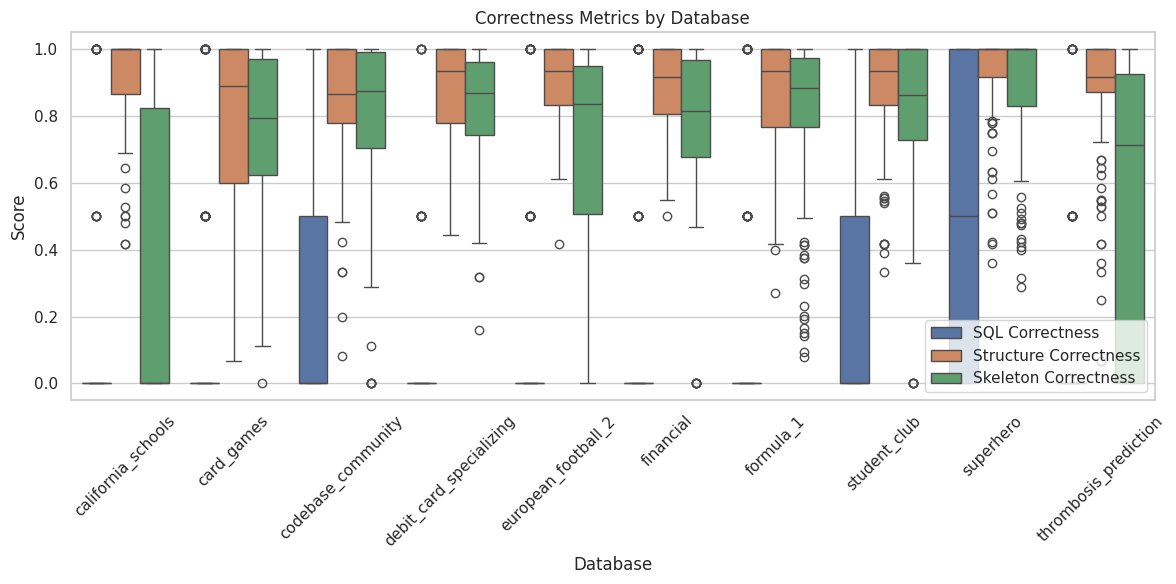

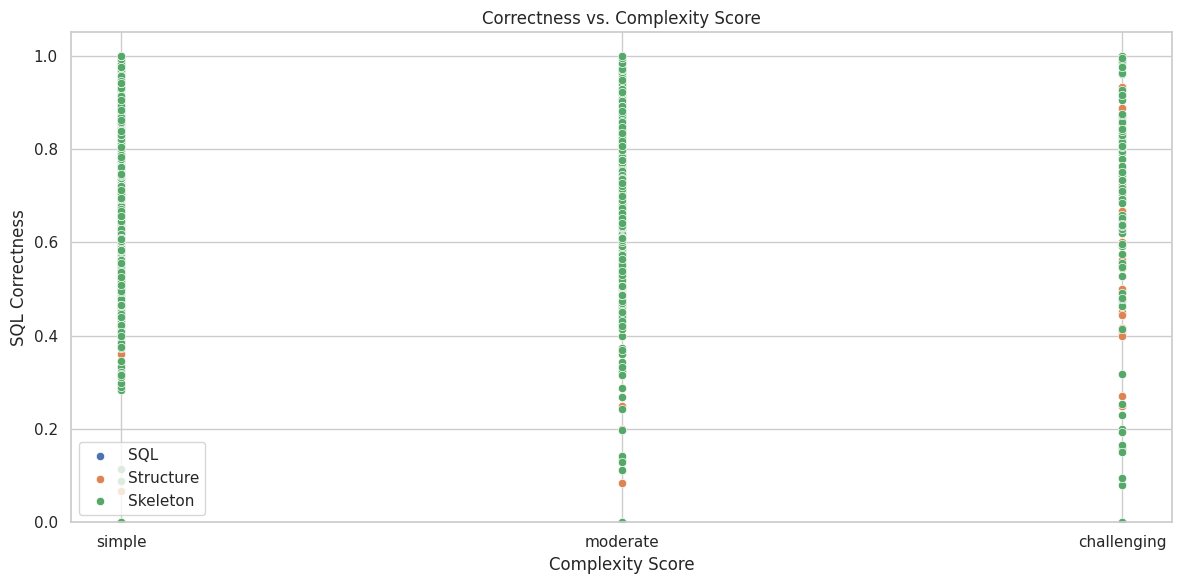

In [ ]:
# Plot 1: Boxplot of correctness scores by database
plt.figure(figsize=(12, 6))
df_melted = df.melt(id_vars='Database', value_vars=['SQL Correctness', 'Structure Correctness', 'Skeleton Correctness'],
                    var_name='Metric', value_name='Score')
sns.boxplot(data=df_melted, x='Database', y='Score', hue='Metric')
plt.title("Correctness Metrics by Database")
plt.ylim(-0.05, 1.05)
plt.legend(loc='lower right')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Plot 2: Scatter plot of correctness vs. complexity
plt.figure(figsize=(12, 6))
sns.scatterplot(data=df, x='Complexity Score', y='SQL Correctness', label='SQL')
sns.scatterplot(data=df, x='Complexity Score', y='Structure Correctness', label='Structure')
sns.scatterplot(data=df, x='Complexity Score', y='Skeleton Correctness', label='Skeleton')
# sns.scatterplot(data=df, x='Complexity Score', y='Accuracy Scores', label='Accuracy')

plt.title("Correctness vs. Complexity Score")
plt.ylim(0, 1.05)
plt.legend()
plt.tight_layout()
plt.show()


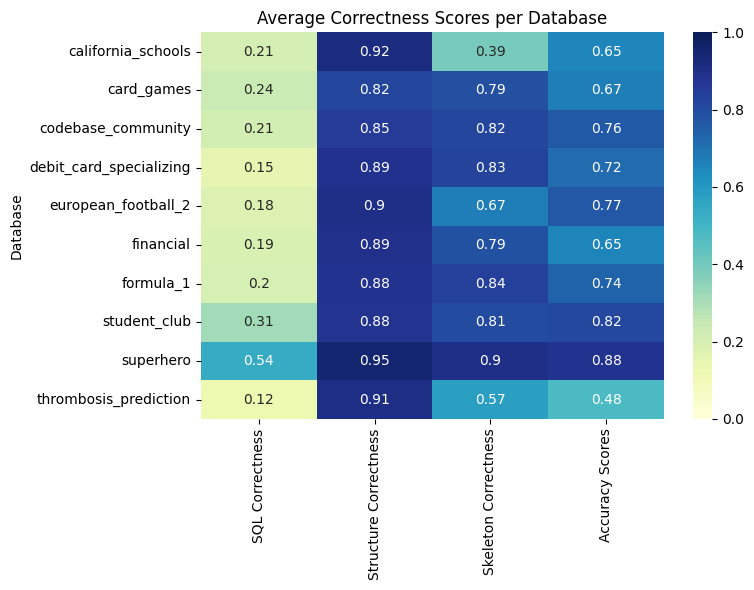

In [ ]:
# Plot 3: Heatmap of average scores per database
df_no_invalid = df[df['Accuracy Scores'] != 2]
pivot_df = df_no_invalid.groupby('Database')[['SQL Correctness', 'Structure Correctness', 'Skeleton Correctness', 'Accuracy Scores']].mean()
plt.figure(figsize=(8, 6))
sns.heatmap(pivot_df, annot=True, cmap='YlGnBu', vmin=0, vmax=1)
plt.title("Average Correctness Scores per Database")
plt.tight_layout()
plt.show()